# TOMOseq data analysis pipeline

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore, variation
import random
import multiprocessing
import seaborn
import scipy

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Describe funciton to process de data

In [2]:
def accessData(list_files, list_labels):
    """opens the read/transcript/gene counts of each file"""
    #create empty dictionary to store the dataframes
    dic_dataframes = {}
    #iterate to get the file names
    #make a counter to access the correct label
    count = 0
    for file in list_files:
        #open each file
        data_frame = pd.read_csv(file, sep='\t', compression='gzip', index_col=0)
        #add the dataframe as an element of a dictionary with key the filename
        dic_dataframes[list_labels[count]] = data_frame
        count = count + 1
    
    return dic_dataframes


def saveCSV(dic_data, label):
    """Save dataframes inside dictionary to csv files"""
    for key in dic_data:
        dic_data[key].to_csv(key+'_'+label+'.tsv.gz', sep='\t', compression='gzip')
    
    return print('Files saved')


def tomoseqFilter(row, thr, n):
    condition = False
    #first check that there is more than 4 sections reaching the thresholod for each gene
    if sum(row>thr)>4:
        i=0
        #in at lest 3 conecutive sections
        while i<n-2:
            if sum(row[i:i+3]>thr) >= 3:
                condition = True
                i = n
            else:
                i= i + 1    
    return condition


def removeGmGenes(df):
    g = []
    for idx in df.index:
        if 'Gm' in idx:
            gid = idx.rsplit('Gm')[1].rsplit('_')[0]
            if sum([n in [str(r) for r in range(10)] for n in gid]) == len(gid):
                g.append(idx)
    return df.loc[[idx for idx in df.index if idx not in g]]

def filterMtRiboTOMOseq2(dic_data, remove_mt = False, remove_ribo = False, TOMOseq = False, threshold=10):
    """Filter out mithocondrial and ribosomal genes from the datasets"""
    """tomoseq paper: For correlation analysis, all genes expressed at >10 reads in >1 section were 
    selected prior to total-read-normalization."""
    #create new dictionary to store filtered data
    dic_genes_filtered = {}
    #access each dataframe individually
    for key in dic_data:
        dataframe = dic_data[key]
        #create a list with the gene information
        gene_info = list(dataframe.index.values)
        #we will make a table with the gene label split in the different parts, 
        #the index is the same as id and the columns have a part of the name
        dataframe_gene_info = pd.DataFrame(columns=['ID', 'name', 'type'], index=gene_info)
        #access each row element of the gene info list to split it 
        
        genes = ['ERCC', 'Kcnq1ot1', 'Mir5109', 'Lars2','Malat1', 'Rn45s', 'Rpl', 'Rps', 'Rik_']
        exclude_genes_index = []
        for index in gene_info: 
            if any(exclude in index for exclude in genes):
                exclude_genes_index.append(index) 
        #we can filter out the genes using their index names we foudn previusly
        dataframe_filtered_s2 = dataframe.drop(exclude_genes_index)
        
        for element in gene_info:
            info_gene = element.split('_')
            #assign values to rows by the row name (index) with loc, 
            #each value of the list to save will be saved in a column
            dataframe_gene_info.loc[element] = [info_gene[0], info_gene[1], info_gene[-1]]
        if remove_mt == True:
            #select from the gene_info df the rows with chr MT
            positions = []
            for gene_name in dataframe_gene_info['name']:
                positions.append('mt.' in gene_name)
            #use the true false positions to selet the rows
            dataframe_gene_info_mt=dataframe_gene_info.loc[positions]
            #get the row index values from them and tansform to list
            mt_index = list(dataframe_gene_info_mt.index.values)
            #we can filter out the MT genes using their index names
            dataframe_filtered_s3 = dataframe_filtered_s2.drop(mt_index)
            print('MT genes removed')
        if remove_mt == False:
            dataframe_filtered_s3 = dataframe_filtered_s2
            print('MT genes NOT removed')
        
        if remove_ribo == True:
        #select from the gene_info df the rows with ribosomal genes and store their index 
            ribosomal_genes_index = []
            for index in dataframe_gene_info.index.values:
                if 'rRNA' in dataframe_gene_info.loc[index][2]:#'Rp'
                    ribosomal_genes_index.append(index) 

            #we can filter out the ribosomal genes using their index names we foudn previusly
            dataframe_filtered_s4 = dataframe_filtered_s3.drop(ribosomal_genes_index)
            print('Ribo genes removed')
        if remove_ribo == False:
            dataframe_filtered_s4 = dataframe_filtered_s3
            print('Ribo genes NOT removed')
            
        if TOMOseq == False:
            dataframe_filtered_s5 = dataframe_filtered_s4
            print('No TOMOseq filtering')
        if TOMOseq == True:
            #make a new dataframe to save TOMOseq filtration
            dataframe_filtered_s5 = pd.DataFrame(columns=dataframe_filtered_s4.columns)
            #go through the dataframe rows to select the ones that have more than X transcripts in at least 3 consecutive sections
            n_sections = len(dataframe_filtered_s4.columns)

            new_data = dataframe_filtered_s4.apply(tomoseqFilter, axis=1, result_type='reduce', args=(threshold, n_sections))
            
            idx_list=[]
            for index in new_data.index:
                if new_data.loc[index]:
                    idx_list.append(index)
            
            dataframe_filtered_s5 = dataframe_filtered_s4.loc[idx_list]
            print('TOMOseq filtering')
            
        #remove Gm genes using Anna's formula
        dataframe_filtered_s6 = removeGmGenes(dataframe_filtered_s5)
        #save the filtered dataframe into the new dictionary
        dic_genes_filtered[key] = dataframe_filtered_s6
    
    return dic_genes_filtered



def findNumberColumns(dic_data):
    """Find the position of the median value of total transcripts across sections to use for normalilzation
    prints the number of columns and returns the total transcript counts per sections"""
    #make an empty list to store the info
    number_columns = list()
    #make a count
    count = 0
    #empty dictionary to store total trancript counts
    dic_total = {}
    for key in dic_data:
        data_frame_total = dic_data[key].sum(axis='index')
        total_values = list(data_frame_total)
        #sort the total transcript values
        total_values.sort()
        dic_total[key] = total_values
        #get the total transcript counts per section
        number_columns.append(len(list(dic_data[key].columns.values)))
        #print number of valules 
        print('Number of values '+key +': ', number_columns[count])
        count = count + 1
    
    return dic_total


def normalizeTO(dic_data, list_factor):
    """Normalize to median/mean/factor
    1. divide by the total reads in each column (normalization)
    2. multiply by the factor of total raeds across sections (scaling)"""
    #make a counter for the smaple number to select the median position
    count = 0
    #make a dictionary to store the normalized datasets
    dic_normal = {}
    #Get each dataframe
    for key in dic_data:
        #get the total transcript counts per section
        data_frame_total = dic_data[key].sum(axis='index')
        #divide each section by the total of the section
        data_frame_normal_s1 = dic_data[key].divide(data_frame_total, axis='columns')
        #multiply by the meadian value 
        data_frame_normal = data_frame_normal_s1.multiply(list_factor[count])
        count = count + 1
        #save the dataframe to the dictionary
        dic_normal[key] = data_frame_normal
    
    return dic_normal



## 2- Normalization to library size
### A) Normalize. Try whatever normalization you prefer: median, mean, ERCC, house-keeping… whatever you want. 

I will normalize to median.

TOMOseq paper: Read counts were normalized to total counts per section or by linear fits to spike-in RNA input/output plots (Figures S1A–S1D), depending on whether or not we wanted to retain differences in total reads per section caused by embryo geometry. The data were then renormalized to the median of total reads across sections in order to ensure that count numbers roughly corresponded to the number of mapped reads. For the 1D analyses described in Figures 2, 3, and 4 we used total read normalization in order to prevent biases caused by embryo geometry. For the 3D analyses shown in Figures 5, 6, and 7, on the other hand, we preferred spike-in normalization in order to be able to align microscopy data to sequencing data by crosscorrelation based on total read profiles (Figure 5E) (Junker et al., 2015).

In [3]:
#access de data
#Create a variable list with the file names and one with the labels to use as dictionary keys
path = ''

file_names = [path + 'Muscle_1_genes.t.t.counts_filtered.tsv.gz', 
             path + 'Muscle_2_genes.t.t.counts_filtered.tsv.gz',
              path + 'Muscle_3_genes.t.t.counts_filtered.tsv.gz', 
             path + 'Muscle_4_genes.t.t.counts_filtered.tsv.gz']
labels = ['Muscle_1', 'Muscle_2', 'Muscle_3', 'Muscle_4']

#use accessData() function to obtain a dictonary with each dataset with labels as key
data_filtered_s1 = accessData(file_names, labels)
data_filtered_s1['Muscle_3']

,001,002,003,004,005,006,007,008,009,010,...,037,038,039,040,041,042,043,044,045,046
new_gene,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000000001_Gnai3_ProteinCoding,0.000000,1.00000,0.00000,1.000000,0.000000,4.001466,2.000244,2.000244,4.001466,1.000000,...,4.001466,4.001466,4.001466,2.000244,2.000244,0.000000,2.000244,1.000000,3.000733,1.000000
ENSMUSG00000000028_Cdc45_ProteinCoding,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,2.000244,0.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000000031_H19_lincRNA,17.033297,53.33937,72.63146,126.931567,103.278896,264.317512,254.729915,382.251826,457.583676,115.602376,...,315.833914,167.353127,209.229770,87.926511,73.649355,15.025699,62.466401,25.073545,34.137731,21.051448
ENSMUSG00000000037_Scml2_ProteinCoding,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,3.000733,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000000049_Apoh_ProteinCoding,0.000000,1.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000244,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000118506_1700094D03Rik_ProteinCoding,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000118537_Shld3_ProteinCoding,0.000000,0.00000,0.00000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
ENSMUSG00000118559_A930007A09Rik_ProteinCoding,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [4]:
#Find mitocondrial and ribosomal genes which are expressed equally across sections. Therefore not interesting
data_filtered_s3 = filterMtRiboTOMOseq2(data_filtered_s1, remove_mt = False, remove_ribo = False, TOMOseq = False, threshold=4)
data_filtered_s3

MT genes NOT removed
Ribo genes NOT removed
No TOMOseq filtering
MT genes NOT removed
Ribo genes NOT removed
No TOMOseq filtering
MT genes NOT removed
Ribo genes NOT removed
No TOMOseq filtering
MT genes NOT removed
Ribo genes NOT removed
No TOMOseq filtering


{'Muscle_1':                                                     001         002  \
 new_gene                                                              
 ENSMUSG00000000001_Gnai3_ProteinCoding         0.000000    0.000000   
 ENSMUSG00000000028_Cdc45_ProteinCoding         0.000000    0.000000   
 ENSMUSG00000000031_H19_lincRNA               186.144646  239.860345   
 ENSMUSG00000000037_Scml2_ProteinCoding         0.000000    0.000000   
 ENSMUSG00000000049_Apoh_ProteinCoding          0.000000    0.000000   
 ...                                                 ...         ...   
 ENSMUSG00000118623_AL935121.1_ProteinCoding    0.000000    0.000000   
 ENSMUSG00000118638_AL805980.1_ProteinCoding    0.000000    0.000000   
 ENSMUSG00000118652_AL645799.1_lincRNA          0.000000    1.000000   
 ENSMUSG00000118653_AC159819.1_ProteinCoding    0.000000    0.000000   
 ENSMUSG00000118659_AC158307.1_lincRNA          0.000000    0.000000   
 
                                                  

In [5]:
data_filtered_s4={}
for key in data_filtered_s3:
    remove=[]
    for index in data_filtered_s3[key].index:
        if sum([i>60000 for i in data_filtered_s3[key].loc[index]])>=1:
            remove.append(index)
    data_filtered_s4[key]=data_filtered_s3[key].drop(remove, axis=0)
data_filtered_s4

{'Muscle_1':                                                     001         002  \
 new_gene                                                              
 ENSMUSG00000000001_Gnai3_ProteinCoding         0.000000    0.000000   
 ENSMUSG00000000028_Cdc45_ProteinCoding         0.000000    0.000000   
 ENSMUSG00000000031_H19_lincRNA               186.144646  239.860345   
 ENSMUSG00000000037_Scml2_ProteinCoding         0.000000    0.000000   
 ENSMUSG00000000049_Apoh_ProteinCoding          0.000000    0.000000   
 ...                                                 ...         ...   
 ENSMUSG00000118623_AL935121.1_ProteinCoding    0.000000    0.000000   
 ENSMUSG00000118638_AL805980.1_ProteinCoding    0.000000    0.000000   
 ENSMUSG00000118652_AL645799.1_lincRNA          0.000000    1.000000   
 ENSMUSG00000118653_AC159819.1_ProteinCoding    0.000000    0.000000   
 ENSMUSG00000118659_AC158307.1_lincRNA          0.000000    0.000000   
 
                                                  

In [6]:
#Find the position of the median value of the total transcript counts per section
data_filtered_s4_total = findNumberColumns(data_filtered_s4)

Number of values Muscle_1:  37
Number of values Muscle_2:  45
Number of values Muscle_3:  46
Number of values Muscle_4:  43


In [7]:
#1.Find the median: find de median value of total counts across sections by sorting the total transcript counts
#create list of medians
medians = list()

#for TM4_TAR is the position 24
medians.append(data_filtered_s4_total['Muscle_1'][18])

##for TM4_TAR is the position 24
medians.append(data_filtered_s4_total['Muscle_2'][23])

medians.append(data_filtered_s4_total['Muscle_3'][23])

medians.append(data_filtered_s4_total['Muscle_4'][22])

medians

[195876.94529325352, 169962.921295428, 197488.9862732507, 158211.28469067707]

In [8]:
#normalize datasets
data_filtered_s3_normal = normalizeTO(data_filtered_s4, medians)
data_filtered_s3_normal

{'Muscle_1':                                                     001         002  \
 new_gene                                                              
 ENSMUSG00000000001_Gnai3_ProteinCoding         0.000000    0.000000   
 ENSMUSG00000000028_Cdc45_ProteinCoding         0.000000    0.000000   
 ENSMUSG00000000031_H19_lincRNA               527.233998  652.843653   
 ENSMUSG00000000037_Scml2_ProteinCoding         0.000000    0.000000   
 ENSMUSG00000000049_Apoh_ProteinCoding          0.000000    0.000000   
 ...                                                 ...         ...   
 ENSMUSG00000118623_AL935121.1_ProteinCoding    0.000000    0.000000   
 ENSMUSG00000118638_AL805980.1_ProteinCoding    0.000000    0.000000   
 ENSMUSG00000118652_AL645799.1_lincRNA          0.000000    2.721766   
 ENSMUSG00000118653_AC159819.1_ProteinCoding    0.000000    0.000000   
 ENSMUSG00000118659_AC158307.1_lincRNA          0.000000    0.000000   
 
                                                  

## 3- Correlations replicates

In [9]:
#calculate sum of all sections
data_filtered_s3_normal_total={}
for key in data_filtered_s3_normal:
    dataframe = data_filtered_s3_normal[key]
    data_filtered_s3_normal_total[key] = dataframe.sum(axis=1)
data_filtered_s3_normal_total

{'Muscle_1': new_gene
 ENSMUSG00000000001_Gnai3_ProteinCoding            45.189864
 ENSMUSG00000000028_Cdc45_ProteinCoding             5.630061
 ENSMUSG00000000031_H19_lincRNA                 26523.758098
 ENSMUSG00000000037_Scml2_ProteinCoding             8.173010
 ENSMUSG00000000049_Apoh_ProteinCoding             19.882572
                                                    ...     
 ENSMUSG00000118623_AL935121.1_ProteinCoding        0.983312
 ENSMUSG00000118638_AL805980.1_ProteinCoding        0.481802
 ENSMUSG00000118652_AL645799.1_lincRNA             14.276654
 ENSMUSG00000118653_AC159819.1_ProteinCoding        2.776028
 ENSMUSG00000118659_AC158307.1_lincRNA              1.599146
 Length: 15617, dtype: float64,
 'Muscle_2': new_gene
 ENSMUSG00000000001_Gnai3_ProteinCoding                34.355331
 ENSMUSG00000000028_Cdc45_ProteinCoding                 5.226037
 ENSMUSG00000000031_H19_lincRNA                     34339.782410
 ENSMUSG00000000037_Scml2_ProteinCoding                 3.

In [10]:
#calculate total coverage per sample and mean of all samples
data_coverage_total={}
for key in data_filtered_s3_normal_total:
    dataframe = data_filtered_s3_normal_total[key]
    data_coverage_total[key] = dataframe.sum(axis=0)
data_coverage_total

{'Muscle_1': 7247446.975850381,
 'Muscle_2': 7648331.458294259,
 'Muscle_3': 9084493.36856953,
 'Muscle_4': 6803085.241699114}

#### Muscle 1 and muscle 2

In [11]:
#add the genes that are not present in both dataset with count of 0
data_filtered_s3_normal_filtered_total_modified={}
data_filtered_s3_normal_filtered_total_modified['Muscle_2']=data_filtered_s3_normal_total['Muscle_2']
for index in list(set(data_filtered_s3_normal_total['Muscle_1'].index) - set(data_filtered_s3_normal_total['Muscle_2'].index)):
    data_filtered_s3_normal_filtered_total_modified['Muscle_2'].loc[index]=0
data_filtered_s3_normal_filtered_total_modified['Muscle_2']


new_gene
ENSMUSG00000000001_Gnai3_ProteinCoding          34.355331
ENSMUSG00000000028_Cdc45_ProteinCoding           5.226037
ENSMUSG00000000031_H19_lincRNA               34339.782410
ENSMUSG00000000037_Scml2_ProteinCoding           3.621558
ENSMUSG00000000049_Apoh_ProteinCoding           15.135084
                                                 ...     
ENSMUSG00000031651_Triml1_ProteinCoding          0.000000
ENSMUSG00000057219_Armc7_ProteinCoding           0.000000
ENSMUSG00000068815_Olfr1143_ProteinCoding        0.000000
ENSMUSG00000039097_Rln1_ProteinCoding            0.000000
ENSMUSG00000052270_Fpr2_ProteinCoding            0.000000
Length: 16489, dtype: float64

In [12]:
data_filtered_s3_normal_filtered_total_modified['Muscle_1']=data_filtered_s3_normal_total['Muscle_1']
for index in list(set(data_filtered_s3_normal_total['Muscle_2'].index) - set(data_filtered_s3_normal_total['Muscle_1'].index)):
    data_filtered_s3_normal_filtered_total_modified['Muscle_1'].loc[index]=0
data_filtered_s3_normal_filtered_total_modified['Muscle_1']


new_gene
ENSMUSG00000000001_Gnai3_ProteinCoding          45.189864
ENSMUSG00000000028_Cdc45_ProteinCoding           5.630061
ENSMUSG00000000031_H19_lincRNA               26523.758098
ENSMUSG00000000037_Scml2_ProteinCoding           8.173010
ENSMUSG00000000049_Apoh_ProteinCoding           19.882572
                                                 ...     
ENSMUSG00000023433_Cela3b_ProteinCoding          0.000000
ENSMUSG00000051242_Pcdhb9_ProteinCoding          0.000000
ENSMUSG00000020317_Theg_ProteinCoding            0.000000
ENSMUSG00000095377_Olfr91_ProteinCoding          0.000000
ENSMUSG00000058126_Tpm3.rs7_ProteinCoding        0.000000
Length: 16489, dtype: float64

In [13]:
#normalize total counts between samples
data_total_norm=pd.DataFrame(columns=['Muscle_1', 'Muscle_2'])
data_total_norm['Muscle_1'] = data_filtered_s3_normal_filtered_total_modified['Muscle_1']
data_total_norm['Muscle_2'] = data_filtered_s3_normal_filtered_total_modified['Muscle_2']

data_total_norm

,Muscle_1,Muscle_2
new_gene,,
ENSMUSG00000000001_Gnai3_ProteinCoding,45.189864,34.355331
ENSMUSG00000000028_Cdc45_ProteinCoding,5.630061,5.226037
ENSMUSG00000000031_H19_lincRNA,26523.758098,34339.782410
ENSMUSG00000000037_Scml2_ProteinCoding,8.173010,3.621558
ENSMUSG00000000049_Apoh_ProteinCoding,19.882572,15.135084
...,...,...
ENSMUSG00000023433_Cela3b_ProteinCoding,0.000000,2.163945
ENSMUSG00000051242_Pcdhb9_ProteinCoding,0.000000,1.675097
ENSMUSG00000020317_Theg_ProteinCoding,0.000000,0.828193


In [14]:
data_total_norm_log10=np.log10(data_total_norm+1)
data_total_norm_log10.to_excel("source_data_corr_12.xlsx")
data_total_norm_log10

,Muscle_1,Muscle_2
new_gene,,
ENSMUSG00000000001_Gnai3_ProteinCoding,1.664547,1.548455
ENSMUSG00000000028_Cdc45_ProteinCoding,0.821518,0.794212
ENSMUSG00000000031_H19_lincRNA,4.423651,4.535810
ENSMUSG00000000037_Scml2_ProteinCoding,0.962512,0.664788
ENSMUSG00000000049_Apoh_ProteinCoding,1.319784,1.207771
...,...,...
ENSMUSG00000023433_Cela3b_ProteinCoding,0.000000,0.500229
ENSMUSG00000051242_Pcdhb9_ProteinCoding,0.000000,0.427339
ENSMUSG00000020317_Theg_ProteinCoding,0.000000,0.262022


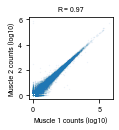

In [15]:
data_total_norm_log10.plot.scatter('Muscle_1', 'Muscle_2', alpha=0.1, figsize=(1.5, 1.5), rasterized=True, s=0.1)
plt.title('R = ' + str(round(data_total_norm_log10.corr().iloc[0,1], 3)), fontsize=7, fontname="Microsoft Sans Serif")
plt.xticks(fontsize=7, fontname="Microsoft Sans Serif")
plt.yticks(fontsize=7, fontname="Microsoft Sans Serif")
plt.xlabel('Muscle 1 counts (log10)', fontsize=7, fontname="Microsoft Sans Serif")
plt.ylabel('Muscle 2 counts (log10)', fontsize=7, fontname="Microsoft Sans Serif")
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('Corr_M1-2.svg', format = 'svg', dpi=300, bbox_inches='tight')   
plt.show()
plt.close()


#### Muscle 1 and muscle 3

In [16]:
#add the genes that are not present in both dataset with count of 0
data_filtered_s3_normal_filtered_total_modified={}
data_filtered_s3_normal_filtered_total_modified['Muscle_3']=data_filtered_s3_normal_total['Muscle_3']
for index in list(set(data_filtered_s3_normal_total['Muscle_1'].index) - set(data_filtered_s3_normal_total['Muscle_3'].index)):
    data_filtered_s3_normal_filtered_total_modified['Muscle_3'].loc[index]=0
data_filtered_s3_normal_filtered_total_modified['Muscle_3']


new_gene
ENSMUSG00000000001_Gnai3_ProteinCoding         99.880768
ENSMUSG00000000028_Cdc45_ProteinCoding         14.401156
ENSMUSG00000000031_H19_lincRNA               8366.367531
ENSMUSG00000000037_Scml2_ProteinCoding          7.485296
ENSMUSG00000000049_Apoh_ProteinCoding          20.012293
                                                ...     
ENSMUSG00000049382_Krt8_ProteinCoding           0.000000
ENSMUSG00000031651_Triml1_ProteinCoding         0.000000
ENSMUSG00000067206_Lrrc66_ProteinCoding         0.000000
ENSMUSG00000068815_Olfr1143_ProteinCoding       0.000000
ENSMUSG00000046634_Pkd1l1_ProteinCoding         0.000000
Length: 17109, dtype: float64

In [17]:
data_filtered_s3_normal_filtered_total_modified['Muscle_1']=data_filtered_s3_normal_total['Muscle_1']
for index in list(set(data_filtered_s3_normal_total['Muscle_3'].index) - set(data_filtered_s3_normal_total['Muscle_1'].index)):
    data_filtered_s3_normal_filtered_total_modified['Muscle_1'].loc[index]=0
data_filtered_s3_normal_filtered_total_modified['Muscle_1']


new_gene
ENSMUSG00000000001_Gnai3_ProteinCoding           45.189864
ENSMUSG00000000028_Cdc45_ProteinCoding            5.630061
ENSMUSG00000000031_H19_lincRNA                26523.758098
ENSMUSG00000000037_Scml2_ProteinCoding            8.173010
ENSMUSG00000000049_Apoh_ProteinCoding            19.882572
                                                  ...     
ENSMUSG00000023039_Krt7_ProteinCoding             0.000000
ENSMUSG00000070336_Fbxo47_ProteinCoding           0.000000
ENSMUSG00000089789_Rdh1_ProteinCoding             0.000000
ENSMUSG00000078451_Ppil6_ProteinCoding            0.000000
ENSMUSG00000069308_Hist1h2bp_ProteinCoding        0.000000
Length: 17109, dtype: float64

In [18]:
#normalize total counts between samples
data_total_norm=pd.DataFrame(columns=['Muscle_1', 'Muscle_3'])
data_total_norm['Muscle_1'] = data_filtered_s3_normal_filtered_total_modified['Muscle_1']
data_total_norm['Muscle_3'] = data_filtered_s3_normal_filtered_total_modified['Muscle_3']

data_total_norm

,Muscle_1,Muscle_3
new_gene,,
ENSMUSG00000000001_Gnai3_ProteinCoding,45.189864,99.880768
ENSMUSG00000000028_Cdc45_ProteinCoding,5.630061,14.401156
ENSMUSG00000000031_H19_lincRNA,26523.758098,8366.367531
ENSMUSG00000000037_Scml2_ProteinCoding,8.173010,7.485296
ENSMUSG00000000049_Apoh_ProteinCoding,19.882572,20.012293
...,...,...
ENSMUSG00000023039_Krt7_ProteinCoding,0.000000,0.681763
ENSMUSG00000070336_Fbxo47_ProteinCoding,0.000000,5.520598
ENSMUSG00000089789_Rdh1_ProteinCoding,0.000000,1.027535


In [19]:
data_total_norm_log10=np.log10(data_total_norm+1)
data_total_norm_log10.to_excel("source_data_corr_13.xlsx")
data_total_norm_log10

,Muscle_1,Muscle_3
new_gene,,
ENSMUSG00000000001_Gnai3_ProteinCoding,1.664547,2.003808
ENSMUSG00000000028_Cdc45_ProteinCoding,0.821518,1.187553
ENSMUSG00000000031_H19_lincRNA,4.423651,3.922589
ENSMUSG00000000037_Scml2_ProteinCoding,0.962512,0.928667
ENSMUSG00000000049_Apoh_ProteinCoding,1.319784,1.322473
...,...,...
ENSMUSG00000023039_Krt7_ProteinCoding,0.000000,0.225765
ENSMUSG00000070336_Fbxo47_ProteinCoding,0.000000,0.814287
ENSMUSG00000089789_Rdh1_ProteinCoding,0.000000,0.306968


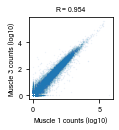

In [20]:
data_total_norm_log10.plot.scatter('Muscle_1', 'Muscle_3', alpha=0.1, figsize=(1.5, 1.5), rasterized=True, s=0.1)
plt.title('R = ' + str(round(data_total_norm_log10.corr().iloc[0,1], 3)), fontsize=7, fontname="Microsoft Sans Serif")
plt.xticks(fontsize=7, fontname="Microsoft Sans Serif")
plt.yticks(fontsize=7, fontname="Microsoft Sans Serif")
plt.xlabel('Muscle 1 counts (log10)', fontsize=7, fontname="Microsoft Sans Serif")
plt.ylabel('Muscle 3 counts (log10)', fontsize=7, fontname="Microsoft Sans Serif")
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('Corr_M1-3.svg', format = 'svg', dpi=300, bbox_inches='tight')   
plt.show()
plt.close()

#### Muscle 1 and muscle 4

In [21]:
#add the genes that are not present in both dataset with count of 0
data_filtered_s3_normal_filtered_total_modified={}
data_filtered_s3_normal_filtered_total_modified['Muscle_4']=data_filtered_s3_normal_total['Muscle_4']
for index in list(set(data_filtered_s3_normal_total['Muscle_1'].index) - set(data_filtered_s3_normal_total['Muscle_4'].index)):
    data_filtered_s3_normal_filtered_total_modified['Muscle_4'].loc[index]=0
data_filtered_s3_normal_filtered_total_modified['Muscle_4']


new_gene
ENSMUSG00000000001_Gnai3_ProteinCoding         32.313561
ENSMUSG00000000003_Pbsn_ProteinCoding           0.447125
ENSMUSG00000000028_Cdc45_ProteinCoding          5.062974
ENSMUSG00000000031_H19_lincRNA               7311.218140
ENSMUSG00000000037_Scml2_ProteinCoding          2.083859
                                                ...     
ENSMUSG00000087303_Lipo2_ProteinCoding          0.000000
ENSMUSG00000089789_Rdh1_ProteinCoding           0.000000
ENSMUSG00000031651_Triml1_ProteinCoding         0.000000
ENSMUSG00000068815_Olfr1143_ProteinCoding       0.000000
ENSMUSG00000050197_Rhox13_ProteinCoding         0.000000
Length: 17455, dtype: float64

In [22]:
data_filtered_s3_normal_filtered_total_modified['Muscle_1']=data_filtered_s3_normal_total['Muscle_1']
for index in list(set(data_filtered_s3_normal_total['Muscle_4'].index) - set(data_filtered_s3_normal_total['Muscle_1'].index)):
    data_filtered_s3_normal_filtered_total_modified['Muscle_1'].loc[index]=0
data_filtered_s3_normal_filtered_total_modified['Muscle_1']


new_gene
ENSMUSG00000000001_Gnai3_ProteinCoding          45.189864
ENSMUSG00000000028_Cdc45_ProteinCoding           5.630061
ENSMUSG00000000031_H19_lincRNA               26523.758098
ENSMUSG00000000037_Scml2_ProteinCoding           8.173010
ENSMUSG00000000049_Apoh_ProteinCoding           19.882572
                                                 ...     
ENSMUSG00000107662_Olfr772_ProteinCoding         0.000000
ENSMUSG00000021337_Scgn_ProteinCoding            0.000000
ENSMUSG00000075196_Olfr1047_ProteinCoding        0.000000
ENSMUSG00000001095_Slc13a2_ProteinCoding         0.000000
ENSMUSG00000094182_Olfr937_ProteinCoding         0.000000
Length: 17455, dtype: float64

In [23]:
#normalize total counts between samples
data_total_norm=pd.DataFrame(columns=['Muscle_1', 'Muscle_4'])
data_total_norm['Muscle_1'] = data_filtered_s3_normal_filtered_total_modified['Muscle_1']
data_total_norm['Muscle_4'] = data_filtered_s3_normal_filtered_total_modified['Muscle_4']

data_total_norm

,Muscle_1,Muscle_4
new_gene,,
ENSMUSG00000000001_Gnai3_ProteinCoding,45.189864,32.313561
ENSMUSG00000000028_Cdc45_ProteinCoding,5.630061,5.062974
ENSMUSG00000000031_H19_lincRNA,26523.758098,7311.218140
ENSMUSG00000000037_Scml2_ProteinCoding,8.173010,2.083859
ENSMUSG00000000049_Apoh_ProteinCoding,19.882572,15.256327
...,...,...
ENSMUSG00000107662_Olfr772_ProteinCoding,0.000000,1.377502
ENSMUSG00000021337_Scgn_ProteinCoding,0.000000,1.000000
ENSMUSG00000075196_Olfr1047_ProteinCoding,0.000000,0.505586


In [24]:
data_total_norm_log10=np.log10(data_total_norm+1)
data_total_norm_log10.to_excel("source_data_corr_14.xlsx")
data_total_norm_log10

,Muscle_1,Muscle_4
new_gene,,
ENSMUSG00000000001_Gnai3_ProteinCoding,1.664547,1.522621
ENSMUSG00000000028_Cdc45_ProteinCoding,0.821518,0.782686
ENSMUSG00000000031_H19_lincRNA,4.423651,3.864049
ENSMUSG00000000037_Scml2_ProteinCoding,0.962512,0.489094
ENSMUSG00000000049_Apoh_ProteinCoding,1.319784,1.211022
...,...,...
ENSMUSG00000107662_Olfr772_ProteinCoding,0.000000,0.376121
ENSMUSG00000021337_Scgn_ProteinCoding,0.000000,0.301030
ENSMUSG00000075196_Olfr1047_ProteinCoding,0.000000,0.177706


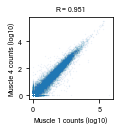

In [25]:
data_total_norm_log10.plot.scatter('Muscle_1', 'Muscle_4', alpha=0.1, figsize=(1.5, 1.5), rasterized=True, s=0.1)
plt.title('R = ' + str(round(data_total_norm_log10.corr().iloc[0,1], 3)), fontsize=7, fontname="Microsoft Sans Serif")
plt.xticks(fontsize=7, fontname="Microsoft Sans Serif")
plt.yticks(fontsize=7, fontname="Microsoft Sans Serif")
plt.xlabel('Muscle 1 counts (log10)', fontsize=7, fontname="Microsoft Sans Serif")
plt.ylabel('Muscle 4 counts (log10)', fontsize=7, fontname="Microsoft Sans Serif")
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('Corr_M1-4.svg', format = 'svg', dpi=300, bbox_inches='tight')   
plt.show()
plt.close()

#### Muscle 2 and muscle 3

In [26]:
#add the genes that are not present in both dataset with count of 0
data_filtered_s3_normal_filtered_total_modified={}
data_filtered_s3_normal_filtered_total_modified['Muscle_3']=data_filtered_s3_normal_total['Muscle_3']
for index in list(set(data_filtered_s3_normal_total['Muscle_2'].index) - set(data_filtered_s3_normal_total['Muscle_3'].index)):
    data_filtered_s3_normal_filtered_total_modified['Muscle_3'].loc[index]=0
data_filtered_s3_normal_filtered_total_modified['Muscle_3']


new_gene
ENSMUSG00000000001_Gnai3_ProteinCoding         99.880768
ENSMUSG00000000028_Cdc45_ProteinCoding         14.401156
ENSMUSG00000000031_H19_lincRNA               8366.367531
ENSMUSG00000000037_Scml2_ProteinCoding          7.485296
ENSMUSG00000000049_Apoh_ProteinCoding          20.012293
                                                ...     
ENSMUSG00000049382_Krt8_ProteinCoding           0.000000
ENSMUSG00000031651_Triml1_ProteinCoding         0.000000
ENSMUSG00000067206_Lrrc66_ProteinCoding         0.000000
ENSMUSG00000068815_Olfr1143_ProteinCoding       0.000000
ENSMUSG00000046634_Pkd1l1_ProteinCoding         0.000000
Length: 17109, dtype: float64

In [27]:
data_filtered_s3_normal_filtered_total_modified['Muscle_2']=data_filtered_s3_normal_total['Muscle_2']
for index in list(set(data_filtered_s3_normal_total['Muscle_3'].index) - set(data_filtered_s3_normal_total['Muscle_2'].index)):
    data_filtered_s3_normal_filtered_total_modified['Muscle_2'].loc[index]=0
data_filtered_s3_normal_filtered_total_modified['Muscle_2']


new_gene
ENSMUSG00000000001_Gnai3_ProteinCoding           34.355331
ENSMUSG00000000028_Cdc45_ProteinCoding            5.226037
ENSMUSG00000000031_H19_lincRNA                34339.782410
ENSMUSG00000000037_Scml2_ProteinCoding            3.621558
ENSMUSG00000000049_Apoh_ProteinCoding            15.135084
                                                  ...     
ENSMUSG00000023039_Krt7_ProteinCoding             0.000000
ENSMUSG00000070336_Fbxo47_ProteinCoding           0.000000
ENSMUSG00000089789_Rdh1_ProteinCoding             0.000000
ENSMUSG00000078451_Ppil6_ProteinCoding            0.000000
ENSMUSG00000069308_Hist1h2bp_ProteinCoding        0.000000
Length: 17109, dtype: float64

In [28]:
#normalize total counts between samples
data_total_norm=pd.DataFrame(columns=['Muscle_2', 'Muscle_3'])
data_total_norm['Muscle_2'] = data_filtered_s3_normal_filtered_total_modified['Muscle_2']
data_total_norm['Muscle_3'] = data_filtered_s3_normal_filtered_total_modified['Muscle_3']

data_total_norm

,Muscle_2,Muscle_3
new_gene,,
ENSMUSG00000000001_Gnai3_ProteinCoding,34.355331,99.880768
ENSMUSG00000000028_Cdc45_ProteinCoding,5.226037,14.401156
ENSMUSG00000000031_H19_lincRNA,34339.782410,8366.367531
ENSMUSG00000000037_Scml2_ProteinCoding,3.621558,7.485296
ENSMUSG00000000049_Apoh_ProteinCoding,15.135084,20.012293
...,...,...
ENSMUSG00000023039_Krt7_ProteinCoding,0.000000,0.681763
ENSMUSG00000070336_Fbxo47_ProteinCoding,0.000000,5.520598
ENSMUSG00000089789_Rdh1_ProteinCoding,0.000000,1.027535


In [29]:
data_total_norm_log10=np.log10(data_total_norm+1)
data_total_norm_log10.to_excel("source_data_corr_23.xlsx")
data_total_norm_log10

,Muscle_2,Muscle_3
new_gene,,
ENSMUSG00000000001_Gnai3_ProteinCoding,1.548455,2.003808
ENSMUSG00000000028_Cdc45_ProteinCoding,0.794212,1.187553
ENSMUSG00000000031_H19_lincRNA,4.535810,3.922589
ENSMUSG00000000037_Scml2_ProteinCoding,0.664788,0.928667
ENSMUSG00000000049_Apoh_ProteinCoding,1.207771,1.322473
...,...,...
ENSMUSG00000023039_Krt7_ProteinCoding,0.000000,0.225765
ENSMUSG00000070336_Fbxo47_ProteinCoding,0.000000,0.814287
ENSMUSG00000089789_Rdh1_ProteinCoding,0.000000,0.306968


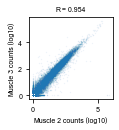

In [30]:
data_total_norm_log10.plot.scatter('Muscle_2', 'Muscle_3', alpha=0.1, figsize=(1.5, 1.5), rasterized=True, s=0.1)
plt.title('R = ' + str(round(data_total_norm_log10.corr().iloc[0,1], 3)), fontsize=7, fontname="Microsoft Sans Serif")
plt.xticks(fontsize=7, fontname="Microsoft Sans Serif")
plt.yticks(fontsize=7, fontname="Microsoft Sans Serif")
plt.xlabel('Muscle 2 counts (log10)', fontsize=7, fontname="Microsoft Sans Serif")
plt.ylabel('Muscle 3 counts (log10)', fontsize=7, fontname="Microsoft Sans Serif")
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('Corr_M2-3.svg', format = 'svg', dpi=300, bbox_inches='tight')   
plt.show()
plt.close()

#### Muscle 2 and muscle 4

In [31]:
#add the genes that are not present in both dataset with count of 0
data_filtered_s3_normal_filtered_total_modified={}
data_filtered_s3_normal_filtered_total_modified['Muscle_4']=data_filtered_s3_normal_total['Muscle_4']
for index in list(set(data_filtered_s3_normal_total['Muscle_2'].index) - set(data_filtered_s3_normal_total['Muscle_4'].index)):
    data_filtered_s3_normal_filtered_total_modified['Muscle_4'].loc[index]=0
data_filtered_s3_normal_filtered_total_modified['Muscle_4']


new_gene
ENSMUSG00000000001_Gnai3_ProteinCoding         32.313561
ENSMUSG00000000003_Pbsn_ProteinCoding           0.447125
ENSMUSG00000000028_Cdc45_ProteinCoding          5.062974
ENSMUSG00000000031_H19_lincRNA               7311.218140
ENSMUSG00000000037_Scml2_ProteinCoding          2.083859
                                                ...     
ENSMUSG00000087303_Lipo2_ProteinCoding          0.000000
ENSMUSG00000089789_Rdh1_ProteinCoding           0.000000
ENSMUSG00000031651_Triml1_ProteinCoding         0.000000
ENSMUSG00000068815_Olfr1143_ProteinCoding       0.000000
ENSMUSG00000050197_Rhox13_ProteinCoding         0.000000
Length: 17455, dtype: float64

In [32]:
data_filtered_s3_normal_filtered_total_modified['Muscle_2']=data_filtered_s3_normal_total['Muscle_2']
for index in list(set(data_filtered_s3_normal_total['Muscle_4'].index) - set(data_filtered_s3_normal_total['Muscle_2'].index)):
    data_filtered_s3_normal_filtered_total_modified['Muscle_2'].loc[index]=0
data_filtered_s3_normal_filtered_total_modified['Muscle_2']


new_gene
ENSMUSG00000000001_Gnai3_ProteinCoding          34.355331
ENSMUSG00000000028_Cdc45_ProteinCoding           5.226037
ENSMUSG00000000031_H19_lincRNA               34339.782410
ENSMUSG00000000037_Scml2_ProteinCoding           3.621558
ENSMUSG00000000049_Apoh_ProteinCoding           15.135084
                                                 ...     
ENSMUSG00000107662_Olfr772_ProteinCoding         0.000000
ENSMUSG00000021337_Scgn_ProteinCoding            0.000000
ENSMUSG00000075196_Olfr1047_ProteinCoding        0.000000
ENSMUSG00000001095_Slc13a2_ProteinCoding         0.000000
ENSMUSG00000094182_Olfr937_ProteinCoding         0.000000
Length: 17455, dtype: float64

In [33]:
#normalize total counts between samples
data_total_norm=pd.DataFrame(columns=['Muscle_2', 'Muscle_4'])
data_total_norm['Muscle_2'] = data_filtered_s3_normal_filtered_total_modified['Muscle_2']
data_total_norm['Muscle_4'] = data_filtered_s3_normal_filtered_total_modified['Muscle_4']

data_total_norm

,Muscle_2,Muscle_4
new_gene,,
ENSMUSG00000000001_Gnai3_ProteinCoding,34.355331,32.313561
ENSMUSG00000000028_Cdc45_ProteinCoding,5.226037,5.062974
ENSMUSG00000000031_H19_lincRNA,34339.782410,7311.218140
ENSMUSG00000000037_Scml2_ProteinCoding,3.621558,2.083859
ENSMUSG00000000049_Apoh_ProteinCoding,15.135084,15.256327
...,...,...
ENSMUSG00000107662_Olfr772_ProteinCoding,0.000000,1.377502
ENSMUSG00000021337_Scgn_ProteinCoding,0.000000,1.000000
ENSMUSG00000075196_Olfr1047_ProteinCoding,0.000000,0.505586


In [34]:
data_total_norm_log10=np.log10(data_total_norm+1)
data_total_norm_log10.to_excel("source_data_corr_24.xlsx")
data_total_norm_log10

,Muscle_2,Muscle_4
new_gene,,
ENSMUSG00000000001_Gnai3_ProteinCoding,1.548455,1.522621
ENSMUSG00000000028_Cdc45_ProteinCoding,0.794212,0.782686
ENSMUSG00000000031_H19_lincRNA,4.535810,3.864049
ENSMUSG00000000037_Scml2_ProteinCoding,0.664788,0.489094
ENSMUSG00000000049_Apoh_ProteinCoding,1.207771,1.211022
...,...,...
ENSMUSG00000107662_Olfr772_ProteinCoding,0.000000,0.376121
ENSMUSG00000021337_Scgn_ProteinCoding,0.000000,0.301030
ENSMUSG00000075196_Olfr1047_ProteinCoding,0.000000,0.177706


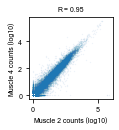

In [35]:
data_total_norm_log10.plot.scatter('Muscle_2', 'Muscle_4', alpha=0.1, figsize=(1.5, 1.5), rasterized=True, s=0.1)
plt.title('R = ' + str(round(data_total_norm_log10.corr().iloc[0,1], 3)), fontsize=7, fontname="Microsoft Sans Serif")
plt.xticks(fontsize=7, fontname="Microsoft Sans Serif")
plt.yticks(fontsize=7, fontname="Microsoft Sans Serif")
plt.xlabel('Muscle 2 counts (log10)', fontsize=7, fontname="Microsoft Sans Serif")
plt.ylabel('Muscle 4 counts (log10)', fontsize=7, fontname="Microsoft Sans Serif")
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('Corr_M2-4.svg', format = 'svg', dpi=300, bbox_inches='tight')   
plt.show()
plt.close()

#### Muscle 3 and muscle 4

In [36]:
#add the genes that are not present in both dataset with count of 0
data_filtered_s3_normal_filtered_total_modified={}
data_filtered_s3_normal_filtered_total_modified['Muscle_4']=data_filtered_s3_normal_total['Muscle_4']
for index in list(set(data_filtered_s3_normal_total['Muscle_3'].index) - set(data_filtered_s3_normal_total['Muscle_4'].index)):
    data_filtered_s3_normal_filtered_total_modified['Muscle_4'].loc[index]=0
data_filtered_s3_normal_filtered_total_modified['Muscle_4']


new_gene
ENSMUSG00000000001_Gnai3_ProteinCoding         32.313561
ENSMUSG00000000003_Pbsn_ProteinCoding           0.447125
ENSMUSG00000000028_Cdc45_ProteinCoding          5.062974
ENSMUSG00000000031_H19_lincRNA               7311.218140
ENSMUSG00000000037_Scml2_ProteinCoding          2.083859
                                                ...     
ENSMUSG00000087303_Lipo2_ProteinCoding          0.000000
ENSMUSG00000089789_Rdh1_ProteinCoding           0.000000
ENSMUSG00000031651_Triml1_ProteinCoding         0.000000
ENSMUSG00000068815_Olfr1143_ProteinCoding       0.000000
ENSMUSG00000050197_Rhox13_ProteinCoding         0.000000
Length: 17455, dtype: float64

In [37]:
data_filtered_s3_normal_filtered_total_modified['Muscle_3']=data_filtered_s3_normal_total['Muscle_3']
for index in list(set(data_filtered_s3_normal_total['Muscle_4'].index) - set(data_filtered_s3_normal_total['Muscle_3'].index)):
    data_filtered_s3_normal_filtered_total_modified['Muscle_3'].loc[index]=0
data_filtered_s3_normal_filtered_total_modified['Muscle_3']


new_gene
ENSMUSG00000000001_Gnai3_ProteinCoding         99.880768
ENSMUSG00000000028_Cdc45_ProteinCoding         14.401156
ENSMUSG00000000031_H19_lincRNA               8366.367531
ENSMUSG00000000037_Scml2_ProteinCoding          7.485296
ENSMUSG00000000049_Apoh_ProteinCoding          20.012293
                                                ...     
ENSMUSG00000107662_Olfr772_ProteinCoding        0.000000
ENSMUSG00000021337_Scgn_ProteinCoding           0.000000
ENSMUSG00000075196_Olfr1047_ProteinCoding       0.000000
ENSMUSG00000001095_Slc13a2_ProteinCoding        0.000000
ENSMUSG00000094182_Olfr937_ProteinCoding        0.000000
Length: 17455, dtype: float64

In [38]:
#normalize total counts between samples
data_total_norm=pd.DataFrame(columns=['Muscle_3', 'Muscle_4'])
data_total_norm['Muscle_3'] = data_filtered_s3_normal_filtered_total_modified['Muscle_3']
data_total_norm['Muscle_4'] = data_filtered_s3_normal_filtered_total_modified['Muscle_4']

data_total_norm

,Muscle_3,Muscle_4
new_gene,,
ENSMUSG00000000001_Gnai3_ProteinCoding,99.880768,32.313561
ENSMUSG00000000028_Cdc45_ProteinCoding,14.401156,5.062974
ENSMUSG00000000031_H19_lincRNA,8366.367531,7311.218140
ENSMUSG00000000037_Scml2_ProteinCoding,7.485296,2.083859
ENSMUSG00000000049_Apoh_ProteinCoding,20.012293,15.256327
...,...,...
ENSMUSG00000107662_Olfr772_ProteinCoding,0.000000,1.377502
ENSMUSG00000021337_Scgn_ProteinCoding,0.000000,1.000000
ENSMUSG00000075196_Olfr1047_ProteinCoding,0.000000,0.505586


In [39]:
data_total_norm_log10=np.log10(data_total_norm+1)
data_total_norm_log10.to_excel("source_data_corr_34.xlsx")
data_total_norm_log10

,Muscle_3,Muscle_4
new_gene,,
ENSMUSG00000000001_Gnai3_ProteinCoding,2.003808,1.522621
ENSMUSG00000000028_Cdc45_ProteinCoding,1.187553,0.782686
ENSMUSG00000000031_H19_lincRNA,3.922589,3.864049
ENSMUSG00000000037_Scml2_ProteinCoding,0.928667,0.489094
ENSMUSG00000000049_Apoh_ProteinCoding,1.322473,1.211022
...,...,...
ENSMUSG00000107662_Olfr772_ProteinCoding,0.000000,0.376121
ENSMUSG00000021337_Scgn_ProteinCoding,0.000000,0.301030
ENSMUSG00000075196_Olfr1047_ProteinCoding,0.000000,0.177706


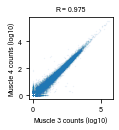

In [40]:
data_total_norm_log10.plot.scatter('Muscle_3', 'Muscle_4', alpha=0.1, figsize=(1.5, 1.5), rasterized=True, s=0.1)
plt.title('R = ' + str(round(data_total_norm_log10.corr().iloc[0,1], 3)), fontsize=7, fontname="Microsoft Sans Serif")
plt.xticks(fontsize=7, fontname="Microsoft Sans Serif")
plt.yticks(fontsize=7, fontname="Microsoft Sans Serif")
plt.xlabel('Muscle 3 counts (log10)', fontsize=7, fontname="Microsoft Sans Serif")
plt.ylabel('Muscle 4 counts (log10)', fontsize=7, fontname="Microsoft Sans Serif")
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('Corr_M3-4.svg', format = 'svg', dpi=300, bbox_inches='tight')   
plt.show()
plt.close()